In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_absolute_error
from sklearn.feature_selection import mutual_info_regression

In [2]:
rs = 42
models = [LinearRegression(), 
          KNeighborsRegressor(),
          DecisionTreeRegressor(random_state=rs), 
          RandomForestRegressor(random_state=rs), 
          SVC(random_state=rs)]
sl_festivals = [pd.to_datetime(d) for d in ['2021-10-19', '2021-11-04', '2021-12-25', '2022-01-15', '2022-03-01']]
sl_holidays = [pd.to_datetime(d) for d in ['2021-10-20', '2021-11-18', '2021-12-18', '2022-01-17', 
                                           '2022-02-04', '2022-02-16']]
Week = {'w1':19, 'w2':20, 'w3':21, 'w4':22}
Phase = {19:'MM2', 20:'End', 21:'Start', 22:'MM1'}
Weight = {19:-1, 20:0, 21:1, 22:0}

In [3]:
def find_week(date, count_from=pd.to_datetime('2021-10-04')):
    return (pd.to_datetime(date) - count_from).days//7

def find_phase(date):
    day = int(pd.to_datetime(date).day)
    if day <= 7:
        return 'MS'
    elif day <= 15:
        return 'MM1'
    elif day <= 23:
        return 'MM2'
    else:
        return 'ME'
    
def find_weight(date):
    date = pd.to_datetime(date)
    if date in sl_festivals:
        return 1
    elif date in sl_holidays:
        return -1
    else:
        return 0

def make_mi_scores(X, y):
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=rs)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    plt.figure(dpi=100, figsize=(8, 5))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.show()
    
def MAPE_score(y_true, y_pred):
    return (sum(abs(y_pred - y_true))/sum(y_true))*100

def evaluate_for_models(models, X, y):
    results = pd.DataFrame({'Model': [], 'ScoreMean': [], 'Score Standard Deviation': []})
    for model in models:
        score = cross_val_score(model, X, y, 
                                scoring=make_scorer(MAPE_score))
        new_result = {'Model': model.__class__.__name__, 
                      'ScoreMean': score.mean(), 'Score Standard Deviation': score.std()}
        results = results.append(new_result, ignore_index=True)
    return results.sort_values(by=['ScoreMean', 'Score Standard Deviation'])

def evaluate_val(models, X_train, X_val, y_train, y_val):
    results = pd.DataFrame({'Model': [], 'MAPE_score': []})
    for model in models:
        m = model.fit(X_train, y_train)
        y_pred = m.predict(X_val)
        new_result = {'Model': model.__class__.__name__, 'MAPE_score': MAPE_score(y_val, y_pred)}
        results = results.append(new_result, ignore_index=True)
    return results.sort_values(by=['MAPE_score'])

In [4]:
train_data_path = '../data-storm-30/train_data.csv'
val_data_path = '../data-storm-30/validation_data.csv'
test_data_path = '../data-storm-30/test_data.csv'

In [5]:
train_df = pd.read_csv(train_data_path)
val_df = pd.read_csv(val_data_path)
test_df = pd.read_csv(test_data_path)

In [6]:
train_df.head()

,CategoryCode,ItemCode,DateID,DailySales
0,category_2,117610,11/6/2021,7
1,category_4,836584,11/18/2021,16
2,category_1,370195,1/24/2022,6
3,category_2,172582,10/30/2021,5
4,category_2,1006009,10/30/2021,5


In [7]:
val_df.head()

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,w1,11
1,category_2,1105009,w1,11
2,category_2,913561,w4,5
3,category_1,1048975,w4,30
4,category_1,17287,w2,60


In [8]:
test_df.head()

,CategoryCode,ItemCode,Week,PredictedSales
0,category_1,43738,w4,NaN
1,category_2,1006090,w1,NaN
2,category_2,1076929,w4,NaN
3,category_1,1081321,w3,NaN
4,category_2,216151,w4,NaN


## <b>Training Dataset</b>

## <b><u>Descriptive Analysis</u></b>

In [9]:
print(train_df.shape)
train_df.info()

(19921, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19921 entries, 0 to 19920
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CategoryCode  19921 non-null  object
 1   ItemCode      19921 non-null  int64 
 2   DateID        19921 non-null  object
 3   DailySales    19921 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 622.7+ KB


<AxesSubplot:xlabel='CategoryCode', ylabel='count'>

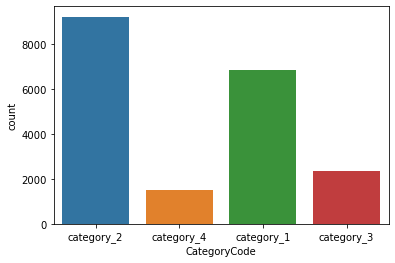

In [10]:
sns.countplot(x=train_df.CategoryCode)

In [11]:
print(train_df.ItemCode.value_counts())

20824      136
132028     136
245581     136
17296      136
119554     136
          ... 
1090114     63
1068883     62
1090303     62
1090294     59
1015621     58
Name: ItemCode, Length: 194, dtype: int64


In [12]:
print(train_df.DateID.value_counts())

12/31/2021    168
1/13/2022     167
12/30/2021    165
1/7/2022      165
12/24/2021    161
             ... 
10/17/2021    129
10/5/2021     129
10/18/2021    128
10/20/2021    128
2/9/2022      125
Name: DateID, Length: 136, dtype: int64


In [13]:
train_df.DailySales.describe()

count    19921.000000
mean         7.351890
std         14.605342
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max        434.000000
Name: DailySales, dtype: float64

## <b><u>Data Cleaning</u></b>

### 1. Missing Values Handling

In [14]:
train_df.isnull().sum()

CategoryCode    0
ItemCode        0
DateID          0
DailySales      0
dtype: int64

In [15]:
val_df.isnull().sum()

CategoryCode    0
ItemCode        0
Week            0
WeeklySales     0
dtype: int64

In [16]:
test_df.isnull().sum()

CategoryCode        0
ItemCode            0
Week                0
PredictedSales    377
dtype: int64

### 2. Outliers Handling

### Training Dataset

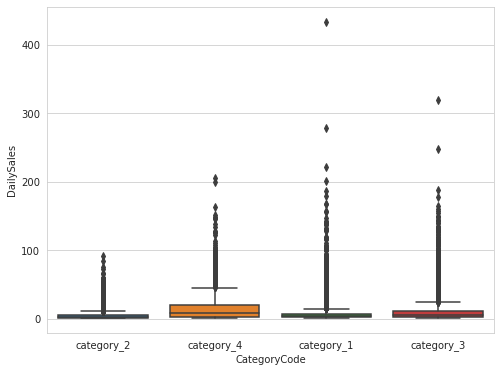

In [17]:
plt.figure(figsize=(8,6))
sns.set_style("whitegrid")
sns.boxplot(x='CategoryCode', y='DailySales', data=train_df)
plt.show()

In [18]:
has_outliers = True
while has_outliers:
    for i in range(1, 5):
        c = 'category_' + str(i)
        c_train = train_df.loc[train_df.CategoryCode == c]
        c_q25, c_q75 = np.percentile(c_train.DailySales, 25), np.percentile(c_train.DailySales, 75)
        c_iqr = c_q75 - c_q25
        upper = c_q75 + (1.5 * c_iqr)
        c_outliers_index = train_df.loc[(train_df.DailySales > upper) & (train_df.CategoryCode == c)].index
        if len(c_outliers_index) == 0:
            has_outliers = False
        else:
            train_df.drop(c_outliers_index, inplace=True)

train_df.shape

(16825, 4)

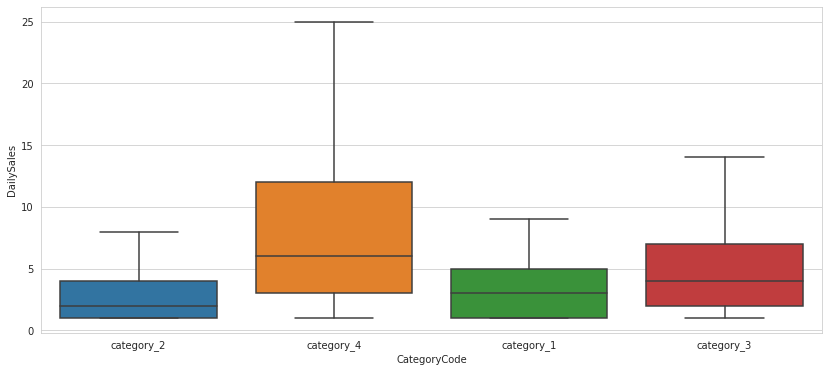

In [19]:
plt.figure(figsize=(14,6))
sns.boxplot(x='CategoryCode', y='DailySales', data=train_df)
plt.show()

## <b><u>Exploratory Analysis</u></b>

### Ploat DailySales for Each Category

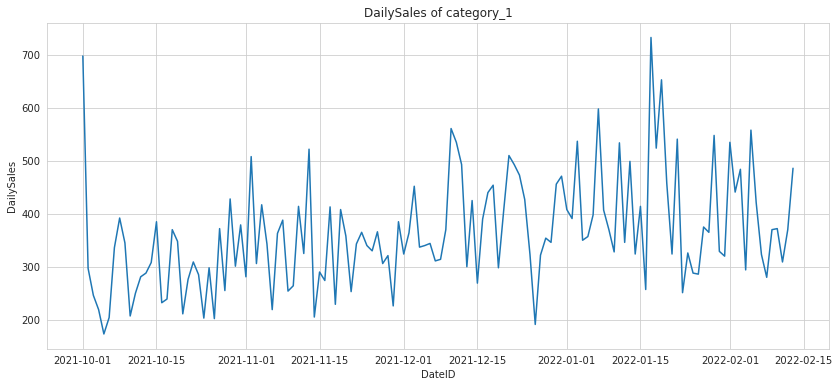

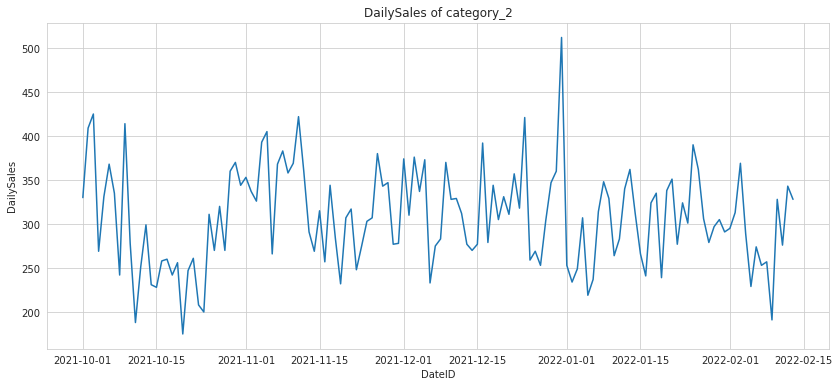

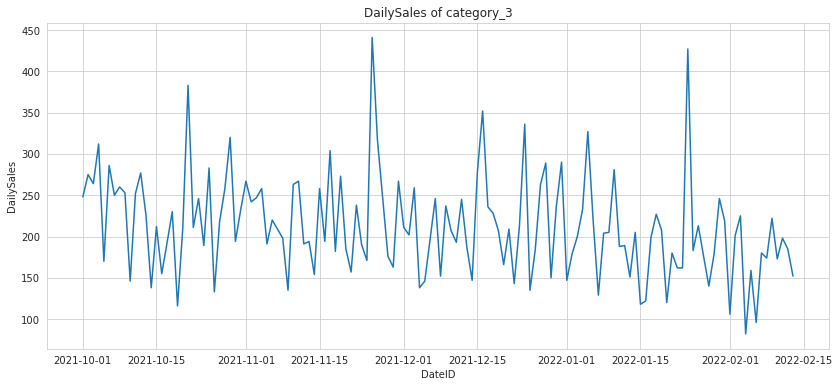

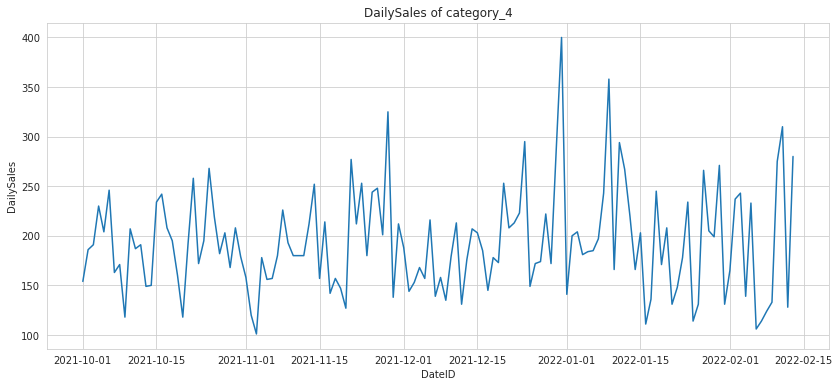

In [20]:
data = pd.read_csv(train_data_path, index_col="DateID", parse_dates=True).sort_index().drop(columns=['ItemCode'])
data = pd.DataFrame(data.groupby(['CategoryCode', 'DateID']).DailySales.sum())

def plt_dailySales(c):
    plt.figure(figsize=(14,6))
    plt.title("DailySales of " + c)
    sns.lineplot(data=data.loc[pd.IndexSlice[c,:],:], x='DateID', y='DailySales')
    plt.show()

for i in range(1, 5):
    plt_dailySales('category_' + str(i))  

### Ploat DailySales of An Item

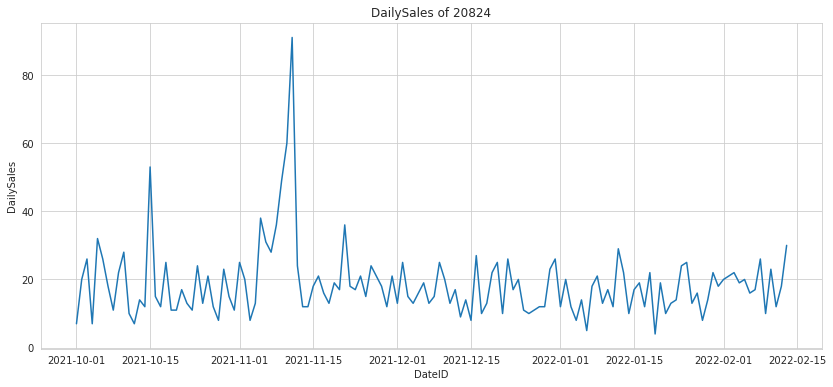

In [21]:
data = pd.read_csv(train_data_path, index_col="DateID", parse_dates=True).sort_index()
data = pd.DataFrame(data.groupby(['ItemCode', 'DateID']).DailySales.sum())

def plt_dailySales(ic):
    plt.figure(figsize=(14,6))
    plt.title("DailySales of " + str(ic))
    sns.lineplot(data=data.loc[pd.IndexSlice[ic,:],:], x='DateID', y='DailySales')
    plt.show()

plt_dailySales(20824) 

In [22]:
make_mi_scores(pd.DataFrame(train_df.ItemCode), train_df.DailySales)

ItemCode    0.24212
Name: MI Scores, dtype: float64

## <b><u>Feature Engineering</u></b>

### 1. Feature Creation

### 1.1. Assign A Week for Dates (0<sup>th</sup> Week Starts From 04-10-2021)

### Add Week

In [23]:
def add_week(row):
    row.Week = find_week(row['DateID'])
    return row

train_df['Week'] = np.nan
w_added_train = train_df.apply(add_week, axis='columns')
w_added_train.sort_values('Week')

,CategoryCode,ItemCode,DateID,DailySales,Week
17484,category_2,1090249,10/2/2021,3,-1
8640,category_2,138742,10/1/2021,4,-1
17003,category_1,145330,10/2/2021,6,-1
2520,category_3,1090024,10/3/2021,3,-1
8645,category_2,836125,10/1/2021,6,-1
...,...,...,...,...,...
6460,category_2,43630,2/11/2022,8,18
7312,category_2,9925,2/11/2022,1,18
16483,category_2,9925,2/7/2022,1,18
1040,category_2,1092184,2/8/2022,3,18


### Ploat WeeklySales for Each Category

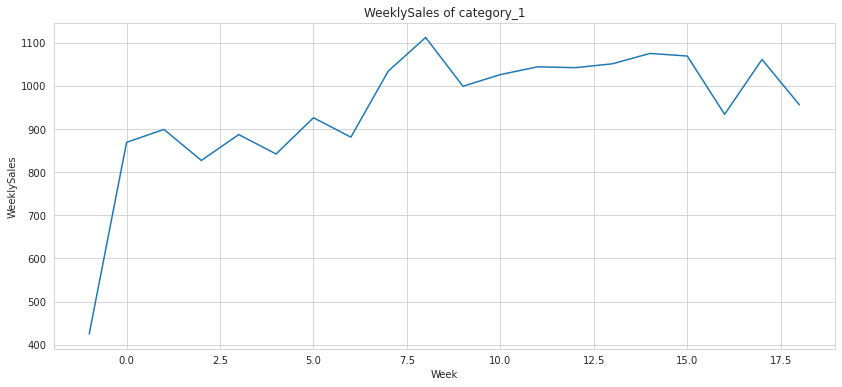

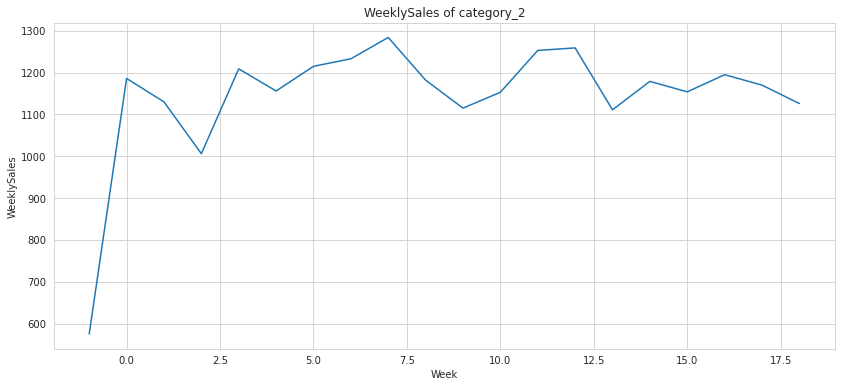

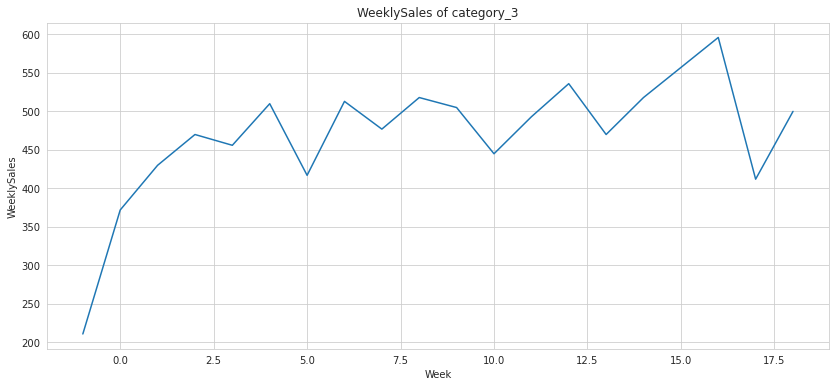

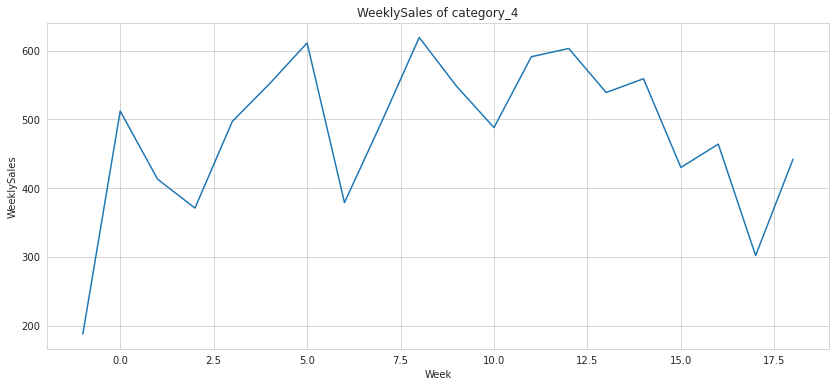

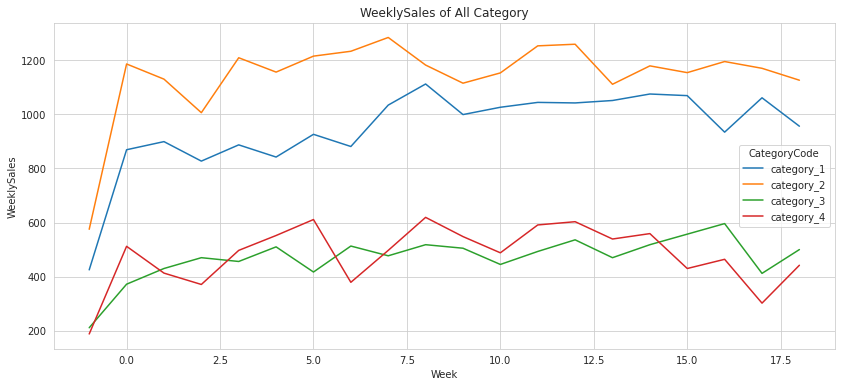

In [24]:
data = w_added_train.copy()
data = pd.DataFrame(data.groupby(['CategoryCode', 'Week']).DailySales.sum())
data.rename(columns={'DailySales': 'WeeklySales'}, inplace=True)

def plt_weeklySales(c):
    plt.figure(figsize=(14,6))
    plt.title("WeeklySales of " + c)
    sns.lineplot(data=data.loc[pd.IndexSlice[c,:],:].reset_index(), x='Week', y='WeeklySales')
    plt.show()
    
for i in range(1, 5):
    plt_weeklySales('category_' + str(i))

plt.figure(figsize=(14,6))
plt.title("WeeklySales of All Category")
sns.lineplot(data=data.loc[pd.IndexSlice[:,:],:], x='Week', y='WeeklySales', hue='CategoryCode')
plt.show()

### Ploat WeeklySales for A Specific Item in A Specific Category

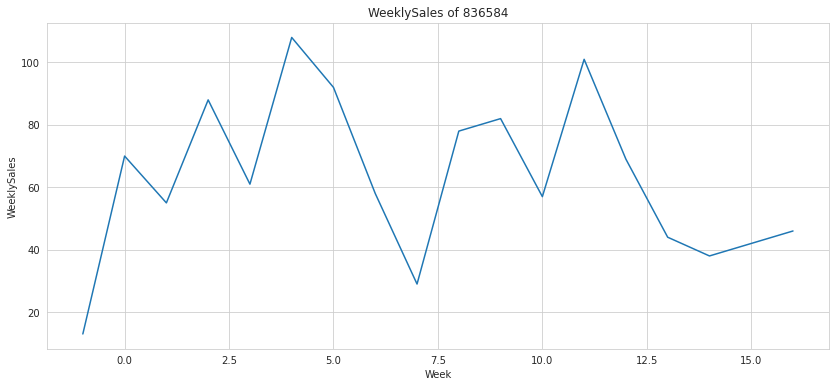

In [25]:
data = w_added_train.copy()
data = pd.DataFrame(data.groupby(['CategoryCode', 'ItemCode', 'Week']).DailySales.sum())
data.rename(columns={'DailySales': 'WeeklySales'}, inplace=True)

def plt_weeklySales(c, ic):
    plt.figure(figsize=(14,6))
    plt.title("WeeklySales of " + str(ic))
    sns.lineplot(data=data.loc[pd.IndexSlice[c, ic, :], :].reset_index(), x='Week', y='WeeklySales')
    plt.show()

CategoryCode = 'category_4'
ItemCode = 836584
plt_weeklySales(CategoryCode, ItemCode)

### 1.2. Assign A Phase for Dates 
<ul>
    <li>MonthStart (MS)</li>
    <li>MonthMiddle1 (MM1)</li>
    <li>MonthMiddle2 (MM2)</li>
    <li>MonthEnd (ME)</li>
</ul>

### Add Phase

In [26]:
n_p = 4
def add_phase(row):
    row.Phase = find_phase(row['DateID'])
    return row

w_added_train['Phase'] = np.nan
pw_added_train = w_added_train.apply(add_phase, axis='columns')
pw_added_train.sort_values('Week')

,CategoryCode,ItemCode,DateID,DailySales,Week,Phase
17484,category_2,1090249,10/2/2021,3,-1,MS
8640,category_2,138742,10/1/2021,4,-1,MS
17003,category_1,145330,10/2/2021,6,-1,MS
2520,category_3,1090024,10/3/2021,3,-1,MS
8645,category_2,836125,10/1/2021,6,-1,MS
...,...,...,...,...,...,...
6460,category_2,43630,2/11/2022,8,18,MM1
7312,category_2,9925,2/11/2022,1,18,MM1
16483,category_2,9925,2/7/2022,1,18,MS
1040,category_2,1092184,2/8/2022,3,18,MM1


### Find The Phase of The n<sup>th</sup> Week

In [27]:
def find_phase_of_week(nth_week):
    wk_p = pd.DataFrame(pd.DataFrame(pw_added_train.groupby(['Week', 'DateID']).Phase.max()).reset_index().groupby(['Week']).Phase.max())
    return wk_p.loc[nth_week, 'Phase']

find_phase_of_week(1)

'MM2'

### Ploat WeeklySales for Each Category Including Phases

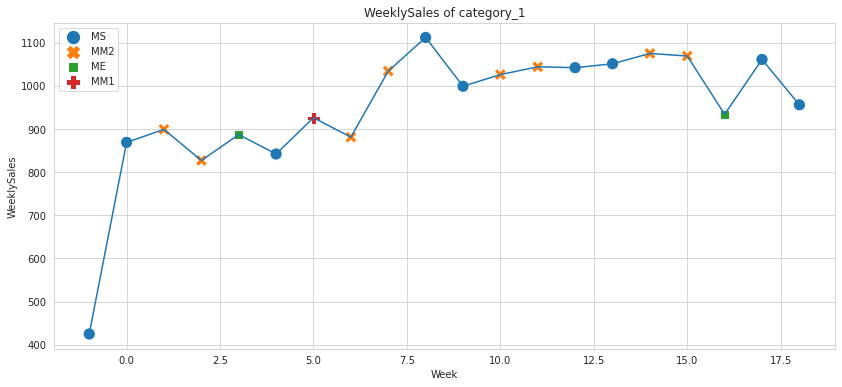

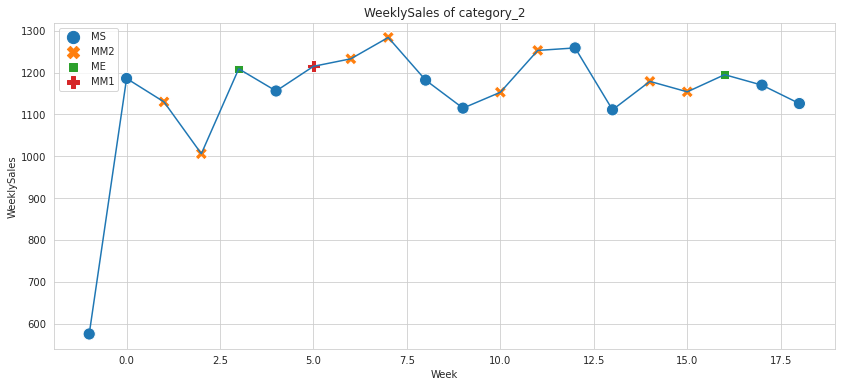

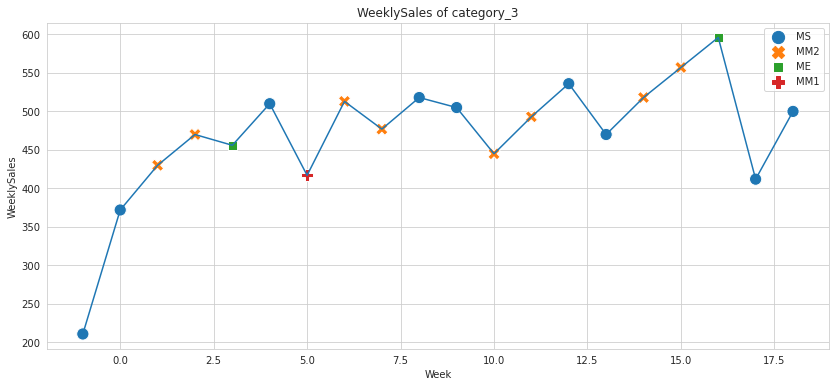

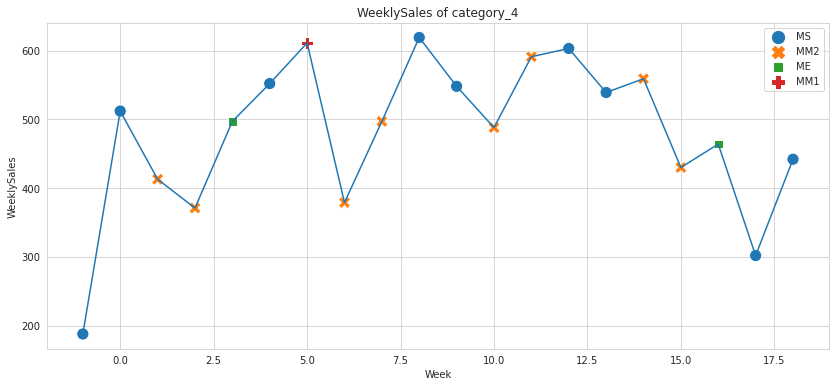

In [28]:
def phase_of_week(row):
    row.Phase = find_phase_of_week(row.name[1])
    return row

data = pw_added_train.copy()
data = pd.DataFrame(data.groupby(['CategoryCode', 'Week']).DailySales.sum())
data.rename(columns={'DailySales': 'WeeklySales'}, inplace=True)
data['Phase'] = np.nan
data = data.apply(phase_of_week, axis='columns')

def plt_weeklySales_with_phase(c):
    plt.figure(figsize=(14,6))
    plt.title("WeeklySales of " + c)
    sns.scatterplot(data=data.loc[pd.IndexSlice[c,:, :],:].reset_index(), x="Week", y="WeeklySales", 
                    hue="Phase", style="Phase", size="Phase", sizes=[150]*n_p)
    sns.lineplot(data=data.loc[pd.IndexSlice[c,:, :],:].reset_index(), x='Week', y='WeeklySales')
    plt.show()

for i in range(1, 5):
    plt_weeklySales_with_phase('category_' + str(i))

### Ploat WeeklySales for A Specific Item in A Specific Category Including Phases

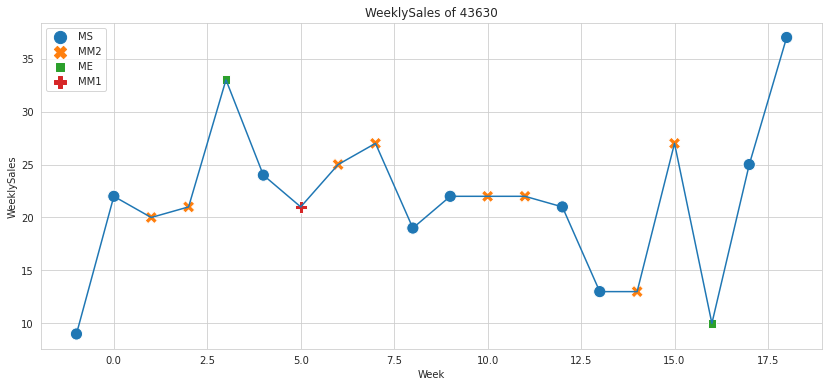

In [29]:
def phase_of_week(row):
    row.Phase = find_phase_of_week(row.name[1])
    return row

ItemCode = 43630
data = pw_added_train.copy()
data = pd.DataFrame(data.groupby(['ItemCode', 'Week']).DailySales.sum())
data.rename(columns={'DailySales': 'WeeklySales'}, inplace=True)
data['Phase'] = np.nan
data = data.loc[[ItemCode]]
data = data.apply(phase_of_week, axis='columns')

def plt_weeklySales_with_phase(ic):
    plt.figure(figsize=(14,6))
    plt.title("WeeklySales of " + str(ic))
    sns.scatterplot(data=data.loc[pd.IndexSlice[ic, :], :].reset_index(), x="Week", y="WeeklySales", 
                    hue="Phase", style="Phase", size="Phase", sizes=[150]*n_p)
    sns.lineplot(data=data.loc[pd.IndexSlice[ic, :], :].reset_index(), x='Week', y='WeeklySales')
    plt.show()

plt_weeklySales_with_phase(ItemCode)

### 1.3. Assign A Weight for Dates 
<ul>
    <li>-1 for holidays</li>
    <li> 0 for normal days</li>
    <li> 1 for festivals</li>
</ul>

### Add Weight

<AxesSubplot:xlabel='Weight', ylabel='count'>

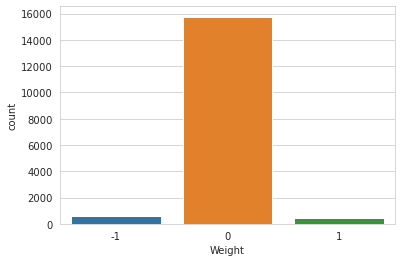

In [30]:
def add_weight(row):
    row.Weight = find_weight(row['DateID'])
    return row

pw_added_train['Weight'] = np.nan
wpw_added_train = pw_added_train.apply(add_weight, axis='columns')
sns.countplot(x=wpw_added_train.Weight)

### Find The Weight of The n<sup>th</sup> Week

In [31]:
def find_weight_of_week(nth_week):
    wk_wgt = pd.DataFrame(pd.DataFrame(wpw_added_train.groupby(['Week', 'DateID']).Weight.max()).reset_index().groupby(['Week']).Weight.sum())
    return wk_wgt.loc[nth_week, 'Weight']

find_weight_of_week(15)

-1

### Ploat WeeklySales for Each Category Including Weights

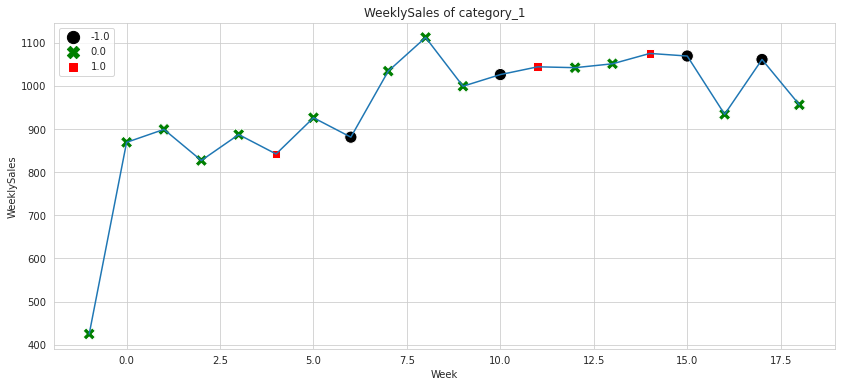

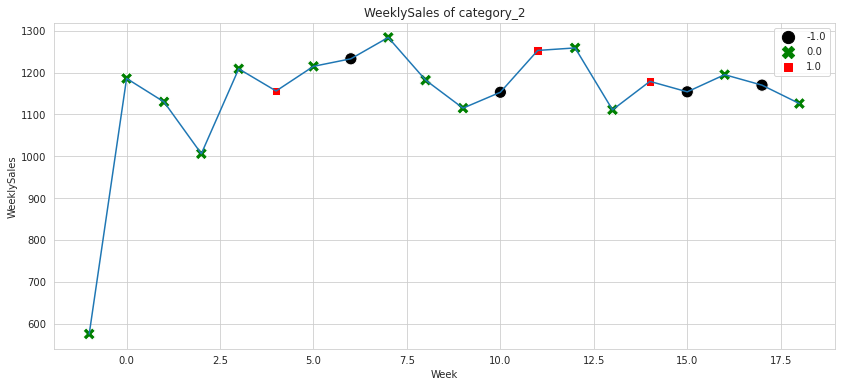

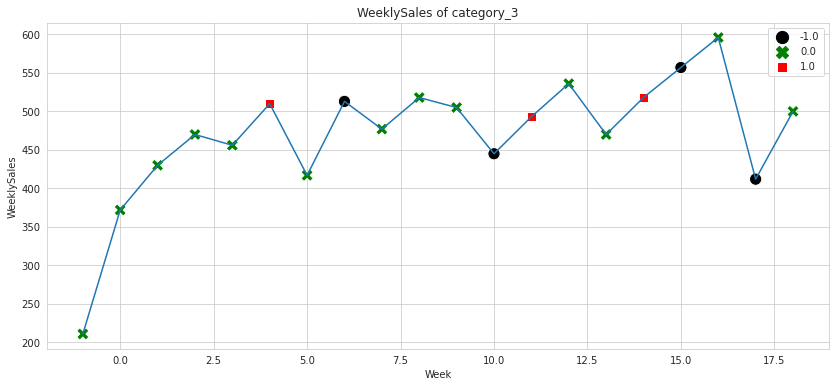

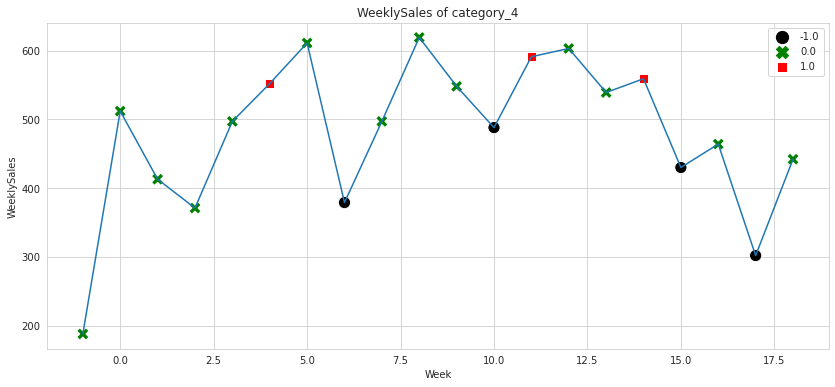

In [32]:
def weight_of_week(row):
    row.Weight = find_weight_of_week(row.name[1])
    return row

data = wpw_added_train.copy()
data = pd.DataFrame(data.groupby(['CategoryCode', 'Week']).DailySales.sum())
data.rename(columns={'DailySales': 'WeeklySales'}, inplace=True)
data['Weight'] = np.nan
data = data.apply(weight_of_week, axis='columns')

def plt_weeklySales_with_weight(c):
    plt.figure(figsize=(14,6))
    plt.title("WeeklySales of " + c)
    sns.scatterplot(data=data.loc[pd.IndexSlice[c,:, :],:].reset_index(), x="Week", y="WeeklySales", 
                    hue="Weight", style="Weight", size="Weight", sizes=(150, 150), 
                    palette={-1: 'black', 0: 'g', 1: 'r'})
    sns.lineplot(data=data.loc[pd.IndexSlice[c,:, :],:].reset_index(), x='Week', y='WeeklySales')
    plt.show()

for i in range(1, 5):
    plt_weeklySales_with_weight('category_' + str(i))

### Ploat WeeklySales for A Specific Item in A Specific Category Including Weights

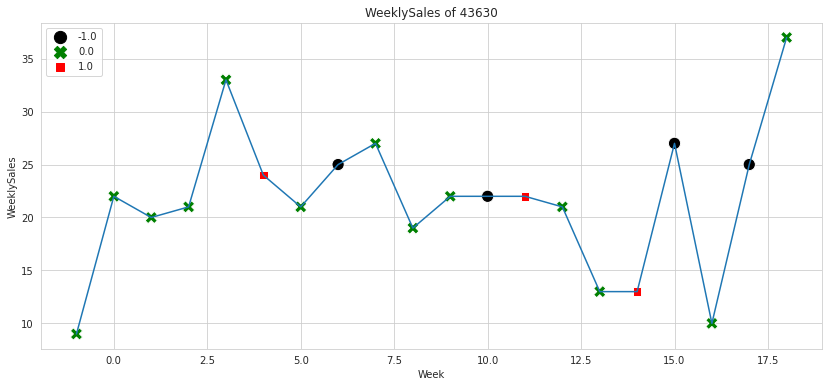

In [33]:
def weight_of_week(row):
    row.Weight = find_weight_of_week(row.name[1])
    return row

ItemCode = 43630
data = wpw_added_train.copy()
data = pd.DataFrame(data.groupby(['ItemCode', 'Week']).DailySales.sum())
data.rename(columns={'DailySales': 'WeeklySales'}, inplace=True)
data['Weight'] = np.nan
data = data.loc[[ItemCode]]
data = data.apply(weight_of_week, axis='columns')

def plt_weeklySales_with_weight(ic):
    plt.figure(figsize=(14,6))
    plt.title("WeeklySales of " + str(ic))
    sns.scatterplot(data=data.loc[pd.IndexSlice[ic,:, :],:].reset_index(), x="Week", y="WeeklySales", 
                    hue="Weight", style="Weight", size="Weight", sizes=(150, 150), 
                    palette={-1: 'black', 0: 'g', 1: 'r'})
    sns.lineplot(data=data.loc[pd.IndexSlice[ic,:, :],:].reset_index(), x='Week', y='WeeklySales')
    plt.show()

plt_weeklySales_with_weight(ItemCode)

#### Create The Final Test Dataset

In [34]:
groupby_ciw_ftrain = pd.DataFrame(wpw_added_train.groupby(['CategoryCode', 'ItemCode', 'Week']).DailySales.sum())
groupby_ciw_ftrain.rename(columns={'DailySales': 'WeeklySales'}, inplace=True)

#### Add Phase

In [35]:
def add_phase(row):
    row.Phase = find_phase_of_week(row.Week)
    return row

groupby_ciw_ftrain = groupby_ciw_ftrain.reset_index()
groupby_ciw_ftrain['Phase'] = np.nan
pw_added_ftrain = groupby_ciw_ftrain.apply(add_phase, axis='columns')
pw_added_ftrain

,CategoryCode,ItemCode,Week,WeeklySales,Phase
0,category_1,3418,-1,11,MS
1,category_1,3418,0,16,MS
2,category_1,3418,1,26,MM2
3,category_1,3418,2,15,MM2
4,category_1,3418,3,21,ME
...,...,...,...,...,...
3655,category_4,1082743,13,24,MS
3656,category_4,1082743,14,9,MM2
3657,category_4,1082743,15,75,MM2
3658,category_4,1082743,16,26,ME


#### Add Weight

In [36]:
def add_weight(row):
    row.Weight = find_weight_of_week(row.Week)
    return row

pw_added_ftrain['Weight'] = np.nan
wpw_added_ftrain = pw_added_ftrain.apply(add_weight, axis='columns')
wpw_added_ftrain

,CategoryCode,ItemCode,Week,WeeklySales,Phase,Weight
0,category_1,3418,-1,11,MS,0
1,category_1,3418,0,16,MS,0
2,category_1,3418,1,26,MM2,0
3,category_1,3418,2,15,MM2,0
4,category_1,3418,3,21,ME,0
...,...,...,...,...,...,...
3655,category_4,1082743,13,24,MS,0
3656,category_4,1082743,14,9,MM2,1
3657,category_4,1082743,15,75,MM2,-1
3658,category_4,1082743,16,26,ME,0


### 2. Feature Encoding

In [37]:
wpw_added_ftrain = wpw_added_ftrain.loc[wpw_added_ftrain.Week != -1]
encoder = ce.OneHotEncoder(cols=['CategoryCode','ItemCode', 'Phase'], return_df=True, use_cat_names=True)
enocoded_train = encoder.fit_transform(wpw_added_ftrain)
enocoded_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3491 entries, 1 to 3659
Columns: 204 entries, CategoryCode_category_1 to Weight
dtypes: int64(204)
memory usage: 5.5 MB


/home/kajanan/ProgramFiles/anaconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [38]:
X = enocoded_train.drop(columns=['WeeklySales'])
y = enocoded_train.WeeklySales

### 3. Feature Selection Based on Feature Importance(Using Mutual Infomation)

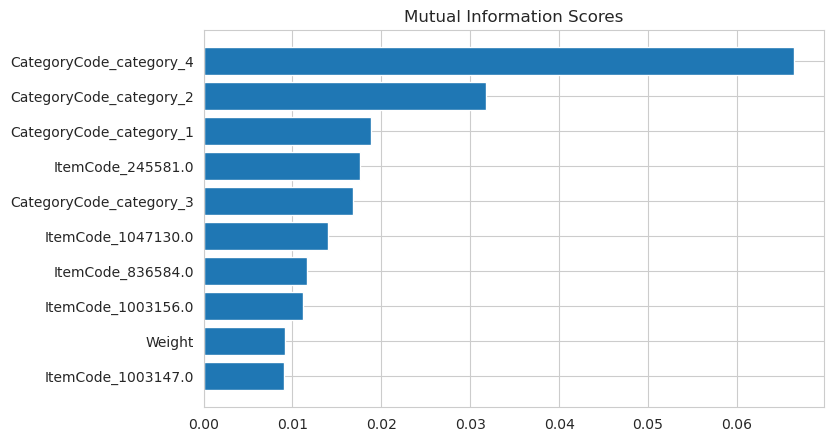

In [39]:
mi_score = make_mi_scores(X, y)
plot_mi_scores(mi_score.head(10))

In [40]:
droppable_features = mi_score.loc[mi_score < 0.0001]

In [41]:
X = X.drop(columns=droppable_features.index)

## <b><u>Evaluate The Models on Training Dataset Using Cross-Validation for Model Selection</u></b>

<ul>
    <li>5-Fold Cross-Validation</li>
    <li>Scoring Method - MAPE</li>
<ul>

In [42]:
evaluate_for_models(models, X, y)

/home/kajanan/ProgramFiles/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,Model,ScoreMean,Score Standard Deviation
3,RandomForestRegressor,5.445308e+01,7.130853e+00
2,DecisionTreeRegressor,5.510833e+01,7.239937e+00
1,KNeighborsRegressor,5.574691e+01,1.861969e+00
4,SVC,5.856447e+01,8.343438e+00
0,LinearRegression,2.151169e+14,5.264901e+13


In [43]:
best_model = RandomForestRegressor(random_state=rs)
parameters = {'n_estimators': np.arange(1, 100, 20), 'max_depth': np.arange(1, 100, 20)}
grdSCV = GridSearchCV(best_model, parameters, scoring=make_scorer(MAPE_score))
grdSCV.fit(X, y)

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': array([ 1, 21, 41, 61, 81]),
                         'n_estimators': array([ 1, 21, 41, 61, 81])},
             scoring=make_scorer(MAPE_score))

In [44]:
grdSCV_result = pd.DataFrame(grdSCV.cv_results_)
grdSCV_result[['param_n_estimators', 'param_max_depth', 'mean_test_score', 
               'std_test_score']].sort_values(by=['mean_test_score', 'std_test_score']).head(2)

,param_n_estimators,param_max_depth,mean_test_score,std_test_score
5,1,21,50.646327,7.182567
12,41,41,50.871124,7.322822


In [45]:
for e, d in [(1, 21), (1, 41)]:
    print(e, d)
    model_blr = BaggingRegressor(base_estimator=RandomForestRegressor(random_state=rs, n_estimators=e, max_depth=d), random_state=rs)
    parameters = {'n_estimators': np.arange(1, 100, 20)}
    grdSCV = GridSearchCV(model_blr, parameters, scoring=make_scorer(MAPE_score))
    grdSCV.fit(X, y)
    grdSCV_result = pd.DataFrame(grdSCV.cv_results_)
    print(grdSCV_result[['param_n_estimators', 'mean_test_score', 
                         'std_test_score']].sort_values(by=['mean_test_score', 'std_test_score']).head(2))

1 21
  param_n_estimators  mean_test_score  std_test_score
1                 21        50.880203        6.914308
3                 61        50.949356        6.926332
1 41
  param_n_estimators  mean_test_score  std_test_score
2                 41        50.620240        7.367974
1                 21        50.709402        7.432198


In [46]:
best_models = [RandomForestRegressor(random_state=rs, n_estimators=1, max_depth=21), 
               BaggingRegressor(base_estimator=RandomForestRegressor(random_state=rs, n_estimators=1, max_depth=41),
                                random_state=rs, n_estimators=41)]

In [47]:
X_train = X
y_train = y

## <b>Validation Dataset</b>

In [48]:
def add_week(row):
    row.Week = Week[row['Week']]
    return row

w_added_val = val_df.apply(add_week, axis='columns')
w_added_val

,CategoryCode,ItemCode,Week,WeeklySales
0,category_2,1044502,19,11
1,category_2,1105009,19,11
2,category_2,913561,22,5
3,category_1,1048975,22,30
4,category_1,17287,20,60
...,...,...,...,...
365,category_2,124954,20,43
366,category_2,40759,19,48
367,category_1,1090303,19,19
368,category_2,1090276,21,6


In [49]:
def add_phase(row):
    row.Phase = Phase[row['Week']]
    return row

w_added_val['Phase'] = np.nan
pw_added_val = w_added_val.apply(add_phase, axis='columns')
pw_added_val

,CategoryCode,ItemCode,Week,WeeklySales,Phase
0,category_2,1044502,19,11,MM2
1,category_2,1105009,19,11,MM2
2,category_2,913561,22,5,MM1
3,category_1,1048975,22,30,MM1
4,category_1,17287,20,60,End
...,...,...,...,...,...
365,category_2,124954,20,43,End
366,category_2,40759,19,48,MM2
367,category_1,1090303,19,19,MM2
368,category_2,1090276,21,6,Start


In [50]:
def add_weight(row):
    row.Weight = Weight[row['Week']]
    return row

pw_added_val['Weight'] = np.nan
wpw_added_val = pw_added_val.apply(add_weight, axis='columns')
wpw_added_val

,CategoryCode,ItemCode,Week,WeeklySales,Phase,Weight
0,category_2,1044502,19,11,MM2,-1
1,category_2,1105009,19,11,MM2,-1
2,category_2,913561,22,5,MM1,0
3,category_1,1048975,22,30,MM1,0
4,category_1,17287,20,60,End,0
...,...,...,...,...,...,...
365,category_2,124954,20,43,End,0
366,category_2,40759,19,48,MM2,-1
367,category_1,1090303,19,19,MM2,-1
368,category_2,1090276,21,6,Start,1


In [51]:
enocoded_val = encoder.transform(wpw_added_val)
enocoded_val

,CategoryCode_category_1,CategoryCode_category_2,CategoryCode_category_3,CategoryCode_category_4,ItemCode_3418.0,ItemCode_3427.0,ItemCode_17287.0,ItemCode_24136.0,ItemCode_35449.0,ItemCode_35530.0,...,ItemCode_1060909.0,ItemCode_1074823.0,ItemCode_1082743.0,Week,WeeklySales,Phase_MS,Phase_MM2,Phase_ME,Phase_MM1,Weight
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,19,11,0,1,0,0,-1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,19,11,0,1,0,0,-1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,22,5,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,22,30,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,20,60,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,0,1,0,0,0,0,0,0,0,0,...,0,0,0,20,43,0,0,0,0,0
366,0,1,0,0,0,0,0,0,0,0,...,0,0,0,19,48,0,1,0,0,-1
367,1,0,0,0,0,0,0,0,0,0,...,0,0,0,19,19,0,1,0,0,-1
368,0,1,0,0,0,0,0,0,0,0,...,0,0,0,21,6,0,0,0,0,1


In [52]:
X_val = enocoded_val.drop(columns=['WeeklySales'])
X_val = X_val.drop(columns=droppable_features.index)
y_val = enocoded_val.WeeklySales

In [53]:
evaluate_val(best_models, X_train, X_val, y_train, y_val)

,Model,MAPE_score
1,BaggingRegressor,68.370056
0,RandomForestRegressor,69.256885


## <b>Test + Validation Dataset</b>

In [54]:
X = pd.concat([X_train, X_val])
X = X.reset_index(drop=True)

In [55]:
y = pd.concat([y_train, y_val])
y = y.reset_index(drop=True)

In [56]:
y.describe()

count    3861.000000
mean       19.498316
std        26.716644
min         1.000000
25%         9.000000
50%        14.000000
75%        23.000000
max       771.000000
Name: WeeklySales, dtype: float64

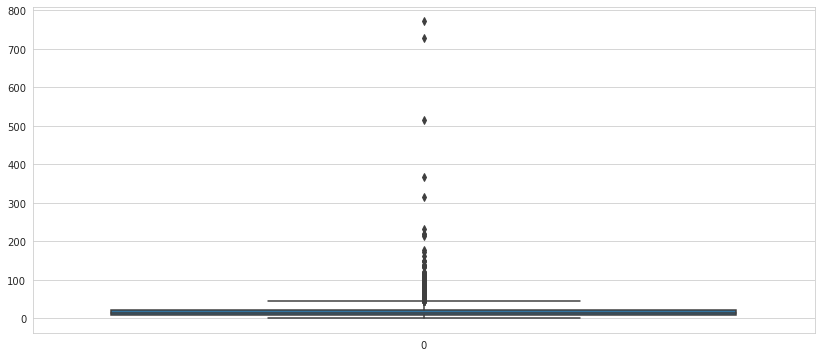

In [57]:
plt.figure(figsize=(14,6))
sns.boxplot(data=y)
plt.show()

In [58]:
has_outliers = True
while has_outliers:
    y_q25, y_q75 = np.percentile(y, 25), np.percentile(y,75)
    y_iqr = y_q75 - y_q25
    upper = y_q75 + (1.5 * y_iqr)
    y_outliers_index = y.loc[y > upper].index
    if len(y_outliers_index) == 0:
        has_outliers = False
    else:
        y.drop(y_outliers_index, inplace=True)
        X.drop(y_outliers_index, inplace=True)

print(X.shape)
print(y.shape)

(3597, 182)
(3597,)


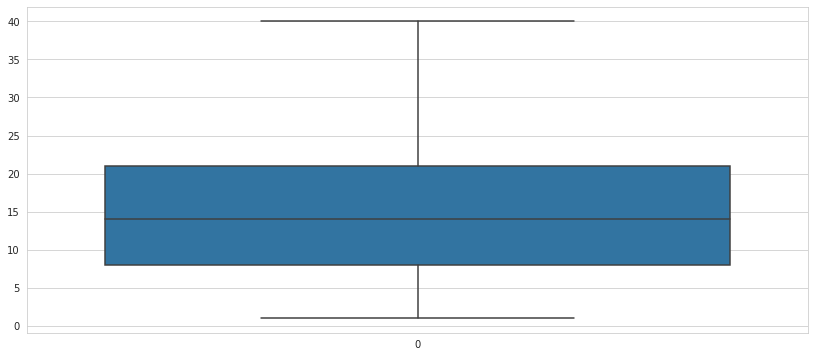

In [59]:
plt.figure(figsize=(14,6))
sns.boxplot(data=y)
plt.show()

In [60]:
evaluate_for_models(best_models, X, y)

,Model,ScoreMean,Score Standard Deviation
1,BaggingRegressor,47.113977,6.014527
0,RandomForestRegressor,51.084091,4.221496


In [61]:
final_model = best_models[1]
final_model

BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=41,
                                                      n_estimators=1,
                                                      random_state=42),
                 n_estimators=41, random_state=42)

## <b>Test Dataset</b>

In [62]:
def add_week(row):
    row.Week = Week[row['Week']]
    return row

w_added_test = test_df.apply(add_week, axis='columns')
w_added_test

,CategoryCode,ItemCode,Week,PredictedSales
0,category_1,43738,22,NaN
1,category_2,1006090,19,NaN
2,category_2,1076929,22,NaN
3,category_1,1081321,21,NaN
4,category_2,216151,22,NaN
...,...,...,...,...
372,category_2,1101571,19,NaN
373,category_2,1090258,22,NaN
374,category_2,906595,19,NaN
375,category_2,32245,19,NaN


In [63]:
def add_phase(row):
    row.Phase = Phase[row['Week']]
    return row

w_added_test['Phase'] = np.nan
pw_added_test = w_added_test.apply(add_phase, axis='columns')
pw_added_test

,CategoryCode,ItemCode,Week,PredictedSales,Phase
0,category_1,43738,22,NaN,MM1
1,category_2,1006090,19,NaN,MM2
2,category_2,1076929,22,NaN,MM1
3,category_1,1081321,21,NaN,Start
4,category_2,216151,22,NaN,MM1
...,...,...,...,...,...
372,category_2,1101571,19,NaN,MM2
373,category_2,1090258,22,NaN,MM1
374,category_2,906595,19,NaN,MM2
375,category_2,32245,19,NaN,MM2


In [64]:
def add_weight(row):
    row.Weight = Weight[row['Week']]
    return row

pw_added_test['Weight'] = np.nan
wpw_added_test = pw_added_test.apply(add_weight, axis='columns')
wpw_added_test

,CategoryCode,ItemCode,Week,PredictedSales,Phase,Weight
0,category_1,43738,22,NaN,MM1,0
1,category_2,1006090,19,NaN,MM2,-1
2,category_2,1076929,22,NaN,MM1,0
3,category_1,1081321,21,NaN,Start,1
4,category_2,216151,22,NaN,MM1,0
...,...,...,...,...,...,...
372,category_2,1101571,19,NaN,MM2,-1
373,category_2,1090258,22,NaN,MM1,0
374,category_2,906595,19,NaN,MM2,-1
375,category_2,32245,19,NaN,MM2,-1


In [65]:
enocoded_test = encoder.transform(wpw_added_test)
enocoded_test

,CategoryCode_category_1,CategoryCode_category_2,CategoryCode_category_3,CategoryCode_category_4,ItemCode_3418.0,ItemCode_3427.0,ItemCode_17287.0,ItemCode_24136.0,ItemCode_35449.0,ItemCode_35530.0,...,ItemCode_1060909.0,ItemCode_1074823.0,ItemCode_1082743.0,Week,PredictedSales,Phase_MS,Phase_MM2,Phase_ME,Phase_MM1,Weight
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,22,NaN,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,19,NaN,0,1,0,0,-1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,22,NaN,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,21,NaN,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,22,NaN,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,0,1,0,0,0,0,0,0,0,0,...,0,0,0,19,NaN,0,1,0,0,-1
373,0,1,0,0,0,0,0,0,0,0,...,0,0,0,22,NaN,0,0,0,1,0
374,0,1,0,0,0,0,0,0,0,0,...,0,0,0,19,NaN,0,1,0,0,-1
375,0,1,0,0,0,0,0,0,0,0,...,0,0,0,19,NaN,0,1,0,0,-1


In [66]:
X_test = enocoded_test.drop(columns=['PredictedSales'])
X_test = X_test.drop(columns=droppable_features.index)
y_test = enocoded_test.PredictedSales

In [67]:
final_model.fit(X, y)

BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=41,
                                                      n_estimators=1,
                                                      random_state=42),
                 n_estimators=41, random_state=42)

In [68]:
test_df['PredictedSales'] = final_model.predict(X_test)
test_df

,CategoryCode,ItemCode,Week,PredictedSales
0,category_1,43738,w4,14.561007
1,category_2,1006090,w1,14.626945
2,category_2,1076929,w4,5.271992
3,category_1,1081321,w3,16.107699
4,category_2,216151,w4,14.296376
...,...,...,...,...
372,category_2,1101571,w1,5.674101
373,category_2,1090258,w4,9.823577
374,category_2,906595,w1,12.736801
375,category_2,32245,w1,17.433219


In [69]:
test_df['ID'] = test_df[['CategoryCode', 'ItemCode', 'Week']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
test_df = test_df.rename(columns={'PredictedSales': 'WeeklySales'})
df = test_df.drop(columns=['CategoryCode', 'ItemCode', 'Week'])
ID = df.pop('ID')
df.insert(0, 'ID', ID)
df.to_csv('test-predicted.csv', index=False)